In [3]:
import pandas as pd
import numpy as np

In [4]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

In [35]:
!pip install --upgrade jedi==0.17.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 39.7 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 13.3 MB/s eta 0:00:00
  Attempting uninstall: parso
    Found existing installation: parso 0.8.3
    Uninstalling parso-0.8.3:
      Successfully uninstalled parso-0.8.3
  Attempting uninstall: jedi
    Found existing installation: jedi 0.18.1
    Uninstalling jedi-0.18.1:
      Successfully uninstalled jedi-0.18.1


In [6]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [7]:
df_train = read_dataframe('./data/yellow_tripdata_2023-01.parquet')
df_val = read_dataframe('./data/yellow_tripdata_2023-02.parquet')

In [8]:
len(df_train), len(df_val)

(3066766, 2913955)

In [16]:
df_train.shape

(3066766, 20)

In [9]:
df_train.duration.describe()

count    3.066766e+06
mean     1.566900e+01
std      4.259435e+01
min     -2.920000e+01
25%      7.116667e+00
50%      1.151667e+01
75%      1.830000e+01
max      1.002918e+04
Name: duration, dtype: float64

In [10]:
df_train = df_train[(df_train.duration >= 1) & (df_train.duration <= 60)]

In [11]:
df_train.shape

(3009173, 20)

In [12]:
(3066766-3009173)/3066766

0.018779717787402103

In [13]:
df_val = df_val[(df_val.duration >= 1) & (df_val.duration <= 60)]

In [16]:
categorical = ['PULocationID', 'DOLocationID']
df_train[categorical] = df_train[categorical].astype(str)
df_val[categorical]=df_val[categorical].astype(str)

In [18]:
numerical = ['trip_distance']

In [19]:
dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [20]:
train_dicts

[{'PULocationID': '161', 'DOLocationID': '141', 'trip_distance': 0.97},
 {'PULocationID': '43', 'DOLocationID': '237', 'trip_distance': 1.1},
 {'PULocationID': '48', 'DOLocationID': '238', 'trip_distance': 2.51},
 {'PULocationID': '138', 'DOLocationID': '7', 'trip_distance': 1.9},
 {'PULocationID': '107', 'DOLocationID': '79', 'trip_distance': 1.43},
 {'PULocationID': '161', 'DOLocationID': '137', 'trip_distance': 1.84},
 {'PULocationID': '239', 'DOLocationID': '143', 'trip_distance': 1.66},
 {'PULocationID': '142', 'DOLocationID': '200', 'trip_distance': 11.7},
 {'PULocationID': '164', 'DOLocationID': '236', 'trip_distance': 2.95},
 {'PULocationID': '141', 'DOLocationID': '107', 'trip_distance': 3.01},
 {'PULocationID': '234', 'DOLocationID': '68', 'trip_distance': 1.8},
 {'PULocationID': '79', 'DOLocationID': '264', 'trip_distance': 7.3},
 {'PULocationID': '164', 'DOLocationID': '143', 'trip_distance': 3.23},
 {'PULocationID': '138', 'DOLocationID': '33', 'trip_distance': 11.43},
 {'

In [21]:
X_train

<3009173x516 sparse matrix of type '<class 'numpy.float64'>'
	with 9027519 stored elements in Compressed Sparse Row format>

In [22]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [23]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

# Validation accuracy
mean_squared_error(y_val, y_pred, squared=False)

7.820190676359081

In [24]:
y_train_pred = lr.predict(X_train)

In [25]:
# Train accuracy
mean_squared_error(y_train, y_train_pred , squared=False)

7.658402938498598

/tmp/ipykernel_4842/124376732.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train_pred,label='Prediction')
/home/ubuntu/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/tmp/ipykernel_4842/124376732.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level fun

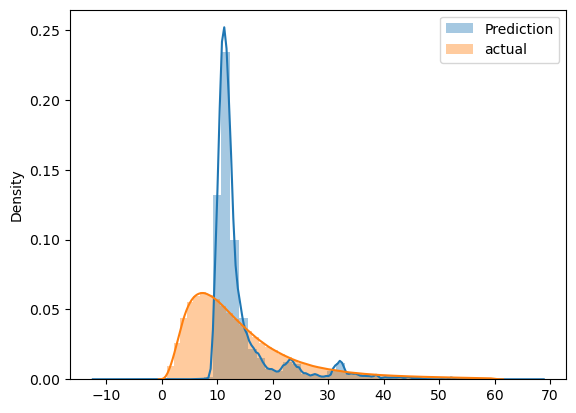

In [26]:
sns.distplot(y_train_pred,label='Prediction')
sns.distplot(y_train, label= "actual")
plt.legend()